In [1]:
import sys, os
import numpy as np
import cupy as xp
import cv2

sys.path.append('./opmap/')

import glob

from opmap.rawCam import RawCam
from opmap.vmemMap import VmemMap
from opmap.phaseMapHilbert import PhaseMapHilbert
from opmap.util import makeMovie

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def makeMovie(path, img_type='png'):
    cmd = 'ffmpeg -r 30 -y -i "{0}/%06d.{1}" -vcodec libx264 -pix_fmt yuv420p "{0}.avi"'.format(path, img_type)
    print(cmd)
    os.system(cmd)

In [3]:
def cvt_cmap(image_gray, cmap):
    assert image_gray.dtype == np.uint8
    if image_gray.ndim == 3: image_gray = image_gray.squeeze(-1)
    sm = plt.cm.ScalarMappable(cmap=cmap)
    color_range = sm.to_rgba(np.linspace(0,1,256))[:,0:3]
    color_range = (color_range*255.0).astype(np.uint8)
    color_range = np.squeeze(np.dstack([color_range[:,2],color_range[:,1],color_range[:,0]]),0)
    channels = [cv2.LUT(image_gray, color_range[:,i]) for i in range(3)]
    return np.dstack(channels)

In [4]:
def impose(i_path, o_path, rate_cam, rate_over):
    im_rgb = cv2.imread(i_path)
    im_out = cv2.addWeighted(im_cam_rgb, rate_cam, im_rgb, rate_over, 0.)
    cv2.imwrite(o_path, im_out)

In [5]:
from scipy import signal

sample_rate = 1000 #[Hz]
fp = np.array([5, 50])
fs = np.array([2, 100])
fn = sample_rate/2
N, Wn = signal.buttord(fp/fn,fs/fn,3,40)
b, a = signal.butter(N,Wn,"band")
b, a


(array([ 4.81199381e-06,  0.00000000e+00, -2.88719629e-05,  0.00000000e+00,
         7.21799072e-05,  0.00000000e+00, -9.62398763e-05,  0.00000000e+00,
         7.21799072e-05,  0.00000000e+00, -2.88719629e-05,  0.00000000e+00,
         4.81199381e-06]),
 array([ 1.00000000e+00, -1.08536916e+01,  5.40749798e+01, -1.63534915e+02,
         3.34367556e+02, -4.86950731e+02,  5.17957575e+02, -4.05453229e+02,
         2.31820967e+02, -9.44162084e+01,  2.60011751e+01, -4.34717726e+00,
         3.33700663e-01]))

In [17]:
#src_list = sorted(glob.glob('C://Users/matsui/Documents/optical/20191126-1/C001H001S*'))
#src_list = sorted(glob.glob('C://Users/matsui/Documents/optical/20191126-1/C001*'))
src_list = sorted(glob.glob('Z://20190925-1\LA\C001*'))
src_list

['Z://20190925-1\\LA\\C001H001S0001',
 'Z://20190925-1\\LA\\C001H001S0002',
 'Z://20190925-1\\LA\\C001H001S0003',
 'Z://20190925-1\\LA\\C001H001S0004',
 'Z://20190925-1\\LA\\C001H001S0005',
 'Z://20190925-1\\LA\\C001H001S0006',
 'Z://20190925-1\\LA\\C001H001S0007',
 'Z://20190925-1\\LA\\C001H001S0008',
 'Z://20190925-1\\LA\\C001H001S0009',
 'Z://20190925-1\\LA\\C001H001S0010',
 'Z://20190925-1\\LA\\C001H001S0011',
 'Z://20190925-1\\LA\\C001H001S0012',
 'Z://20190925-1\\LA\\C001H001S0013',
 'Z://20190925-1\\LA\\C001H001S0014',
 'Z://20190925-1\\LA\\C001H001S0015',
 'Z://20190925-1\\LA\\C001H001S0016',
 'Z://20190925-1\\LA\\C001H001S0017',
 'Z://20190925-1\\LA\\C001H001S0018',
 'Z://20190925-1\\LA\\C001H001S0019',
 'Z://20190925-1\\LA\\C001H001S0020',
 'Z://20190925-1\\LA\\C001H001S0021',
 'Z://20190925-1\\LA\\C001H001S0022']

In [18]:
save=False
for i, path in enumerate(src_list):
    
    if not i in [5]: continue
    
    out_path = path.replace('ExperimentData/', 'AnalysisResult/2019-11-27/')
    if not os.path.exists(out_path): os.makedirs(out_path)
    print(out_path)
    
    cam = RawCam(
        path,
        'sa4',
        512,512,0,500
    )
    plt.imsave(os.path.join(out_path, 'cam.png'), xp.asnumpy(cam.data[0]), cmap='gray')
    
    im_cam = xp.asnumpy(cam.data[0])
    im_cam_gray = (255*im_cam/float(im_cam.max())).astype(np.uint8)
    im_cam_rgb = cvt_cmap(im_cam_gray, cmap=plt.get_cmap('gray'))
    
    if False: 
        path = os.path.join(out_path, 'cam')
        cam.saveImage(path)
    
    cam.setIntROI(500)
    cam.morphROI(erosion=5)
    #cam.roi = xp.asarray(im_roi)
    
    vmem = VmemMap(cam)
    del(cam)
    
    # vmem filtering
    vmem.smooth_xy(5)
    vmem.data = xp.asarray(signal.filtfilt(b,a,xp.asnumpy(vmem.data), axis=0))
    vmem.data = xp.asarray([ signal.medfilt2d(im, 5) for im in xp.asnumpy(vmem.data)])
    
    #vmem.data = vmem.data*-1.0
    
    if True:
        print('saving vmem...')
        path = os.path.join(out_path, 'vmem')
        vmem.saveImage(path)
        makeMovie(path)
        files = glob.glob(os.path.join(path, '*.png'))
        path = path.replace('vmem', 'vmem_imp')
        if not os.path.exists(path):os.makedirs(path)
        [impose(path, path.replace('vmem', 'vmem_imp'),0.5,0.7) for path in files]
        makeMovie(path)
        print('done')

    #vmem.shrink_xy(4)
    vmem.smooth_xy(5)
    pmap = PhaseMapHilbert(vmem, width=512)
    del(vmem)

    if save:
        print('saving pmap...')
        path = os.path.join(out_path, 'pmap')
        pmap.saveImage(path)
        makeMovie(path)
        files = glob.glob(os.path.join(path, '*.png'))
        path = path.replace('pmap', 'pmap_imp')
        if not os.path.exists(path):os.makedirs(path)
        [impose(path, path.replace('pmap', 'pmap_imp'),0.7,0.5) for path in files]
        makeMovie(path)
        print('done')
    
    del(pmap)


Z://20190925-1\LA\C001H001S0006
saving vmem...
ffmpeg -r 30 -y -i "Z://20190925-1\LA\C001H001S0006\vmem/%06d.png" -vcodec libx264 -pix_fmt yuv420p "Z://20190925-1\LA\C001H001S0006\vmem.avi"
ffmpeg -r 30 -y -i "Z://20190925-1\LA\C001H001S0006\vmem_imp/%06d.png" -vcodec libx264 -pix_fmt yuv420p "Z://20190925-1\LA\C001H001S0006\vmem_imp.avi"
done


In [26]:
plt.imsave('roi.bmp', xp.asnumpy(cam.roi), cmap='gray')

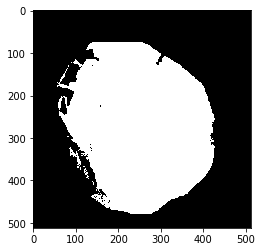

In [13]:
im_roi = cv2.imread(os.path.join('roi.bmp'))
im_roi = cv2.cvtColor(im_roi, cv2.COLOR_BGR2GRAY)
im_roi = ((im_roi==255)*1.0).astype(np.float32)
plt.imshow(im_roi, cmap='gray')

In [11]:
for path in glob.glob("E://AnalysisResult/2019-11-27/*/*/vmem*"):
    makeMovie(path)

ffmpeg -r 30 -y -i "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem/%06d.png" -vcodec rawvideo "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem.avi"
ffmpeg -r 30 -y -i "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem.avi/%06d.png" -vcodec rawvideo "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem.avi.avi"
ffmpeg -r 30 -y -i "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem_imp/%06d.png" -vcodec rawvideo "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem_imp.avi"
ffmpeg -r 30 -y -i "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem_imp.avi/%06d.png" -vcodec rawvideo "E://AnalysisResult/2019-11-27\20191125-1\C001H001S0006\vmem_imp.avi.avi"
ffmpeg -r 30 -y -i "E://AnalysisResult/2019-11-27\20191126-1\C001H001S0003\vmem/%06d.png" -vcodec rawvideo "E://AnalysisResult/2019-11-27\20191126-1\C001H001S0003\vmem.avi"
ffmpeg -r 30 -y -i "E://AnalysisResult/2019-11-27\20191126-1\C001H001S0003\vmem_imp/%06d.png" -vcodec r